<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

['main.ipynb', 'data.py', 'network.py', 'solve.py', 'datasets']

In [3]:
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import imageio
import matplotlib.pyplot as plt
import argparse, os, sys
import cv2
from PIL import Image
import torchvision.models as models

In [4]:
dataset_afw_path="/content/drive/My Drive/Face Alignment DRF/datasets/afw"

Dataset: 300W https://ibug.doc.ic.ac.uk/resources/300-W/

## 1.1 Data preparation

In [5]:
# https://github.com/musyoku/face-alignment-at-3000fps/blob/master/run/train.py

def load_annotations(directory):
	annotations = {}
	fs = os.listdir(directory)
	for filename in fs:
		if filename.endswith(".pts"):
			with open(os.path.join(directory, filename), "r") as f:
				annotation = f.read().strip().split("\n")
				#assert len(annotation) == 72
				landmarks = []
				for location_str in annotation[3:-1]:
					location = location_str.split(" ")
					landmarks.append((float(location[0]), float(location[1])))
				annotations[filename.replace(".pts", "")] = landmarks
	return annotations

In [6]:
#annotations_afw = load_annotations(dataset_afw_path)

### 1.1.1 Test picture

In [7]:
# Load test labels
with open("/content/drive/My Drive/Face Alignment DRF/datasets/afw/1051618982_1.pts", "r") as f:
  afw_test_points = f.read().strip().split("\n")
  landmarks = []
  for location_str in afw_test_points[3:-1]:
    location = location_str.split(" ")
    landmarks.append((float(location[0]), float(location[1])))
afw_test_points = landmarks

In [8]:
afw_test_x = [afw_test_points[i][0]-400 for i in range(68)]
afw_test_y = [afw_test_points[i][1] for i in range(68)]

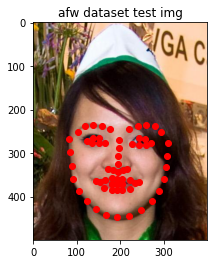

In [9]:
afw_test_img = Image.open(os.path.join(dataset_afw_path, '1051618982_1' + '.jpg'))

# crop
afw_test_img_array = np.array(afw_test_img)
afw_test_nimg_array = afw_test_img_array[0:500, 400:800]
afw_test_nimg = Image.fromarray(afw_test_nimg_array)

plt.figure("afw test") 
plt.imshow(afw_test_nimg)
plt.scatter(afw_test_x,afw_test_y,color='r')
plt.title('afw dataset test img') 
plt.show()

### 1.1.2 Data Washing <font color=red>(To be done)</font>

afw dataset contains pictures with whole human body, not only faces, so faces should be cropped into fixed size first. This dataset also contains pictures with multiple faces, so each should be matched with labels. 

Note that there are situations that a picture contain five faces but only three are labeled, so the number of cropped faces may be more than labels, should be carefully matched.


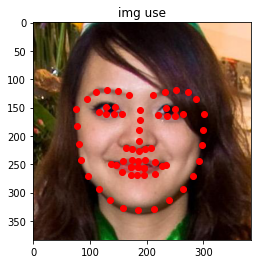

In [10]:
# Use test data to exame network

img_test = afw_test_nimg_array[116:500,8:392] #(384,384,3) ndarray
labelx = [afw_test_x[i]-8 for i in range(68)] #(68,) List, denote colum number
labely = [afw_test_y[i]-116 for i in range(68)] #(68,) List, denote row number

plt.figure("img use") 
plt.imshow(Image.fromarray(img_test))
plt.scatter(labelx,labely,color='r')
plt.title('img use') 
plt.show()

img_tensor = torch.tensor(img_test)
img_tensor = img_tensor.permute(2,0,1) # Change to (C,H,W)
img_tensor = img_tensor.unsqueeze(0) # Add batch=1 (B,C,H,W)
img_tensor = img_tensor.float()

# Network

In [11]:
class CNN_module(nn.Module):
  def __init__(self):
    super(CNN_module, self).__init__()

    self.conv = nn.Sequential(
      OrderedDict([('conv1', nn.Conv2d(in_channels=3,out_channels=5,kernel_size=3,stride=1,padding=1)),
             ('relu1', nn.ReLU()),
             ('pool1', nn.MaxPool2d(kernel_size=2)), #Input(384,384,3), Output(192,192,5)

             ('conv2', nn.Conv2d(in_channels=5,out_channels=10,kernel_size=3,stride=1,padding=1)),
             ('relu2', nn.ReLU()),
             ('pool2', nn.MaxPool2d(kernel_size=2)), #Input(192,192,5), Output(96,96,10)

             ('conv3-1', nn.Conv2d(in_channels=10,out_channels=13,kernel_size=3,stride=1,padding=1)),
             ('relu3-1', nn.ReLU()),
             ('conv3-2', nn.Conv2d(in_channels=13,out_channels=16,kernel_size=3,stride=1,padding=1)),
             ('relu3-2', nn.ReLU()),
             ('pool3', nn.MaxPool2d(kernel_size=2)), #Input(96,96,10), Output(48,18,16)
             
             ('conv4-1', nn.Conv2d(in_channels=16,out_channels=19,kernel_size=3,stride=1,padding=1)),
             ('relu4-1', nn.ReLU()),
             ('conv4-2', nn.Conv2d(in_channels=19,out_channels=22,kernel_size=3,stride=1,padding=1)),
             ('relu4-2', nn.ReLU()),
             ('pool4', nn.MaxPool2d(kernel_size=2)), #Input(48,18,16), Output(24,24,22)

             ('conv5-1', nn.Conv2d(in_channels=22,out_channels=25,kernel_size=3,stride=1,padding=1)),
             ('relu5-1', nn.ReLU()),
             ('conv5-2', nn.Conv2d(in_channels=25,out_channels=28,kernel_size=3,stride=1,padding=1)),
             ('relu5-2', nn.ReLU()),
             ('pool5', nn.MaxPool2d(kernel_size=2)), #Input(24,24,22), Output(12,12,28)

             ('conv6-1', nn.Conv2d(in_channels=28,out_channels=31,kernel_size=3,stride=1,padding=1)),
             ('relu6-1', nn.ReLU()),
             ('conv6-2', nn.Conv2d(in_channels=31,out_channels=34,kernel_size=3,stride=1,padding=1)),
             ('relu6-2', nn.ReLU()),
             ('pool6', nn.MaxPool2d(kernel_size=2)),])) #Input(12,12,28), Output(6,6,34)
      
    self.fc = nn.Sequential(
      OrderedDict([('fc1', nn.Linear(in_features=6*6*34, out_features=128)),
            ('fc2', nn.Linear(in_features=128, out_features=64)),
            ('fc3', nn.Linear(in_features=64, out_features=10)),]))

  def forward(self, x):
    out = self.conv(x)
    out = out.view(-1, 6*6*34)
    out = self.fc(out)
    return out

In [46]:
layer1_cnn = CNN_module()
label = torch.arange(10).reshape(1,10)+1


num_epochs = 100
learning_rate = 0.001
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(layer1_cnn.parameters(),lr=learning_rate)

In [47]:
for epoch in range(num_epochs):
  optimizer.zero_grad()
  outputs = layer1_cnn(img_tensor)
  loss = criterion(outputs, label)
  loss.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.item()))

Epoch [10/100], Loss: 2.9934
Epoch [20/100], Loss: 1.4510
Epoch [30/100], Loss: 1.1413
Epoch [40/100], Loss: 0.9395
Epoch [50/100], Loss: 0.3544
Epoch [60/100], Loss: 0.1302
Epoch [70/100], Loss: 0.5873
Epoch [80/100], Loss: 0.2725
Epoch [90/100], Loss: 0.1790
Epoch [100/100], Loss: 0.1317


In [25]:
loss

tensor(383.9637, grad_fn=<SumBackward0>)

In [26]:
loss.backward()

In [ ]:
def train_gmm(train_data, init_pi, init_mu, init_sigma):
  
  K = init_pi.shape[0] # 5
  N = train_data.shape[0]
  pi, mu, sigma = init_pi, init_mu, init_sigma
  gamma = np.zeros((N,K))
  scores = np.zeros((N,K))
  for iters in range(50):
    for k in range(K):
      scores[:,k] = multivariate_normal.pdf(train_data, mean=mu[k,:], cov=sigma[k,:,:])*pi[k,0]
    gamma = scores/np.sum(scores,axis=1,keepdims=True)

    pi = np.sum(gamma,axis=0)/N
    pi = pi.reshape(K,1)
    mu = np.dot(gamma.T,train_data)/np.sum(gamma,axis=0,keepdims=True).T
    for k in range(K):
      sigma[k,:,:] = np.dot((train_data-mu[k,:]).T,np.multiply(gamma[:,k].reshape(N,1),train_data-mu[k,:]))/np.sum(gamma,axis=0)[k]
  # Hint: multivariate_normal() might be useful
  states = {
      'pi': pi,
      'mu': mu,
      'sigma': sigma,
  }
  ##### TODO: Implement here!! #####
  return states

In [ ]:
def layer2_RF(input,weights):
  a
  return pred

In [ ]:
def loss

In [ ]:
def solver

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import pairwise_distances  # Don't use other functions in sklearn

def train_kmeans(train_data, initial_centroids):
  ##### TODO: Implement here!! #####
  miu = initial_centroids
  for iters in range(50):
    distance = pairwise_distances(train_data,miu) # (16384,16)
    r_TF = distance == np.min(distance,axis=1,keepdims=True)
    r = r_TF+0 # (16384,16), 0-1
    count = np.sum(r,axis=0,keepdims=True).T #(16,1)
    miu = np.dot(train_data.T,r).T / count
    
  # Hint: pairwise_distances() might be useful
  states = {
      'centroids': miu
  }
  ##### TODO: Implement here!! #####
  return states

def test_kmeans(states, test_data):
  result = {}
  ##### TODO: Implement here!! #####
  #print(test_data.shape)
  base = states['centroids']
  distance = pairwise_distances(test_data,base) # (16384,16)
  r_TF = distance == np.min(distance,axis=1,keepdims=True)
  r = r_TF+0
  compressed_data = np.dot(r,base) # TODO: modify here!
  #print(compressed_data.shape)
  ##### TODO: Implement here!! #####
  result['pixel-error'] = calculate_error(test_data, compressed_data)
  return result

### DO NOT CHANGE ###
def calculate_error(data, compressed_data):
  assert data.shape == compressed_data.shape
  error = np.sqrt(np.mean(np.power(data - compressed_data, 2)))
  return error
### DO NOT CHANGE ###

# Load data
img_small = np.array(imageio.imread('q1data/mandrill-small.tiff')) # 128 x 128 x 3
img_large = np.array(imageio.imread('q1data/mandrill-large.tiff')) # 512 x 512 x 3

ndim = img_small.shape[-1]
train_data = img_small.reshape(-1, ndim).astype(float)
test_data = img_large.reshape(-1, ndim).astype(float)

# K-means
num_centroid = 16
initial_centroid_indices = [16041, 15086, 15419,  3018,  5894,  6755, 15296, 11460, 
                            10117, 11603, 11095,  6257, 16220, 10027, 11401, 13404]
initial_centroids = train_data[initial_centroid_indices, :]
states = train_kmeans(train_data, initial_centroids)
result_kmeans = test_kmeans(states, test_data)
print('Kmeans result=', result_kmeans)


from scipy.stats import multivariate_normal  # Don't use other functions in scipy

def train_gmm(train_data, init_pi, init_mu, init_sigma):
  ##### TODO: Implement here!! #####
  
  K = init_pi.shape[0] # 5
  N = train_data.shape[0]
  pi, mu, sigma = init_pi, init_mu, init_sigma
  gamma = np.zeros((N,K))
  scores = np.zeros((N,K))
  for iters in range(50):
    for k in range(K):
      scores[:,k] = multivariate_normal.pdf(train_data, mean=mu[k,:], cov=sigma[k,:,:])*pi[k,0]
    gamma = scores/np.sum(scores,axis=1,keepdims=True)

    pi = np.sum(gamma,axis=0)/N
    pi = pi.reshape(K,1)
    mu = np.dot(gamma.T,train_data)/np.sum(gamma,axis=0,keepdims=True).T
    for k in range(K):
      sigma[k,:,:] = np.dot((train_data-mu[k,:]).T,np.multiply(gamma[:,k].reshape(N,1),train_data-mu[k,:]))/np.sum(gamma,axis=0)[k]
  # Hint: multivariate_normal() might be useful
  states = {
      'pi': pi,
      'mu': mu,
      'sigma': sigma,
  }
  ##### TODO: Implement here!! #####
  return states

def test_gmm(states, test_data):
  result = {}
  ##### TODO: Implement here!! #####
  pi, mu, sigma = states['pi'], states['mu'], states['sigma']
  K = pi.shape[0] # 5
  N = test_data.shape[0]
  probs = np.zeros((N,K))
  for k in range(K):
    probs[:,k] = multivariate_normal.pdf(test_data, mean=mu[k,:], cov=sigma[k,:,:]) * pi[k]
  probs = probs/np.sum(probs,axis=1,keepdims=True)
  compressed_data = mu[np.argmax(probs,axis=1),:]
  ##### TODO: Implement here!! #####
  result['pixel-error'] = calculate_error(test_data, compressed_data)
  return result

# GMM
num_centroid = 5
init_pi = np.ones((num_centroid, 1)) / num_centroid
init_mu = initial_centroids[:num_centroid, :]
init_sigma = np.tile(np.identity(ndim), [num_centroid, 1, 1])*1000.

states = train_gmm(train_data, init_pi, init_mu, init_sigma)
result_gmm = test_gmm(states, test_data)
print('GMM result=', result_gmm)